In [1]:
import pandas as pd
import nltk 
from nltk.corpus import movie_reviews as mr      # taking nltk inbuilt dataset
from nltk.corpus import stopwords
from sklearn.utils import shuffle

In [2]:
stopword= set(stopwords.words('english'))

In [3]:
pos_raw= mr.raw(mr.fileids('pos'))       # raw positive sentences from corpus (unformated form)
neg_raw= mr.raw(mr.fileids('neg'))       # raw negtive sentences from corpus
data_all= pos_raw + neg_raw

In [4]:
from nltk.tokenize import PunktSentenceTokenizer
tokenizer= PunktSentenceTokenizer(data_all)
pos= tokenizer.tokenize(pos_raw)         # splliting sentences from raw data file using Punkt Tokenizer trained on whole corpus

neg= tokenizer.tokenize(neg_raw)

In [5]:
from nltk.stem.wordnet import WordNetLemmatizer
from stemming.porter2 import stem        #lemmat to improve model accuracy
lemmatizer= WordNetLemmatizer()
stemmed_sentences = [[lemmatizer.lemmatize(token) for token in sentence.split(" ")] for sentence in pos]
pos=[]                                    # tokenized--> stemmed--> converted to sentences again
for sentence in stemmed_sentences:
    tmp=""
    for word in sentence:
        tmp= tmp+ str(word)+ " "
    pos.append(tmp)

stemmed_sentences = [[stem(token) for token in sentence.split(" ")] for sentence in neg]
neg=[]
for sentence in stemmed_sentences:
    tmp=""
    for word in sentence:
        tmp= tmp+ str(word)+ " "
    neg.append(tmp)


In [6]:
pos_tag= []       # giving each sentence label 
neg_tag= []
for i in pos:
    pos_tag.append([i,1])
for i in neg:
    neg_tag.append([i,0])

In [7]:
pos= pd.DataFrame(pos_tag,columns=['txt','status'])
neg= pd.DataFrame(neg_tag,columns=['txt','status'])

In [8]:
data= pd.concat([pos,neg],axis=0)          # creating processesable dataframe
data=shuffle(data)

In [9]:
data['status'].value_counts()

1    35941
0    35419
Name: status, dtype: int64

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.cross_validation import train_test_split

F:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
vectorizer= tfidf(stop_words= stopword)       # using TfIdf to make words as features by making word vectors
x= vectorizer.fit_transform(data['txt'])
y= data.status

In [12]:
x_train,x_test,y_train,y_test= train_test_split(x,y,random_state= 42)         # splitting data for cross validation

In [13]:
from sklearn.linear_model import LogisticRegressionCV      # using multiNomial Naive Bayes as classifier

clf= LogisticRegressionCV()

clf.fit(x_train,y_train)
pred= clf.predict(x_test)

In [14]:
clf.Cs                          #best C parameter

10

In [15]:
from sklearn.metrics import classification_report , accuracy_score
print('accuracy=',accuracy_score(y_test,pred))
print(classification_report(y_test, pred))

accuracy= 0.9275224215246637
             precision    recall  f1-score   support

          0       0.90      0.96      0.93      8778
          1       0.96      0.89      0.93      9062

avg / total       0.93      0.93      0.93     17840



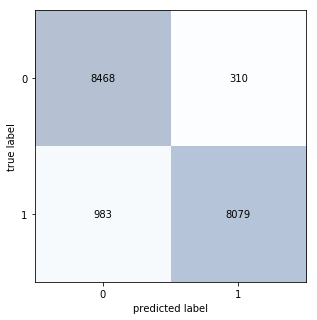

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

In [17]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vectorizer, clf, 30)

In [18]:
import numpy as np

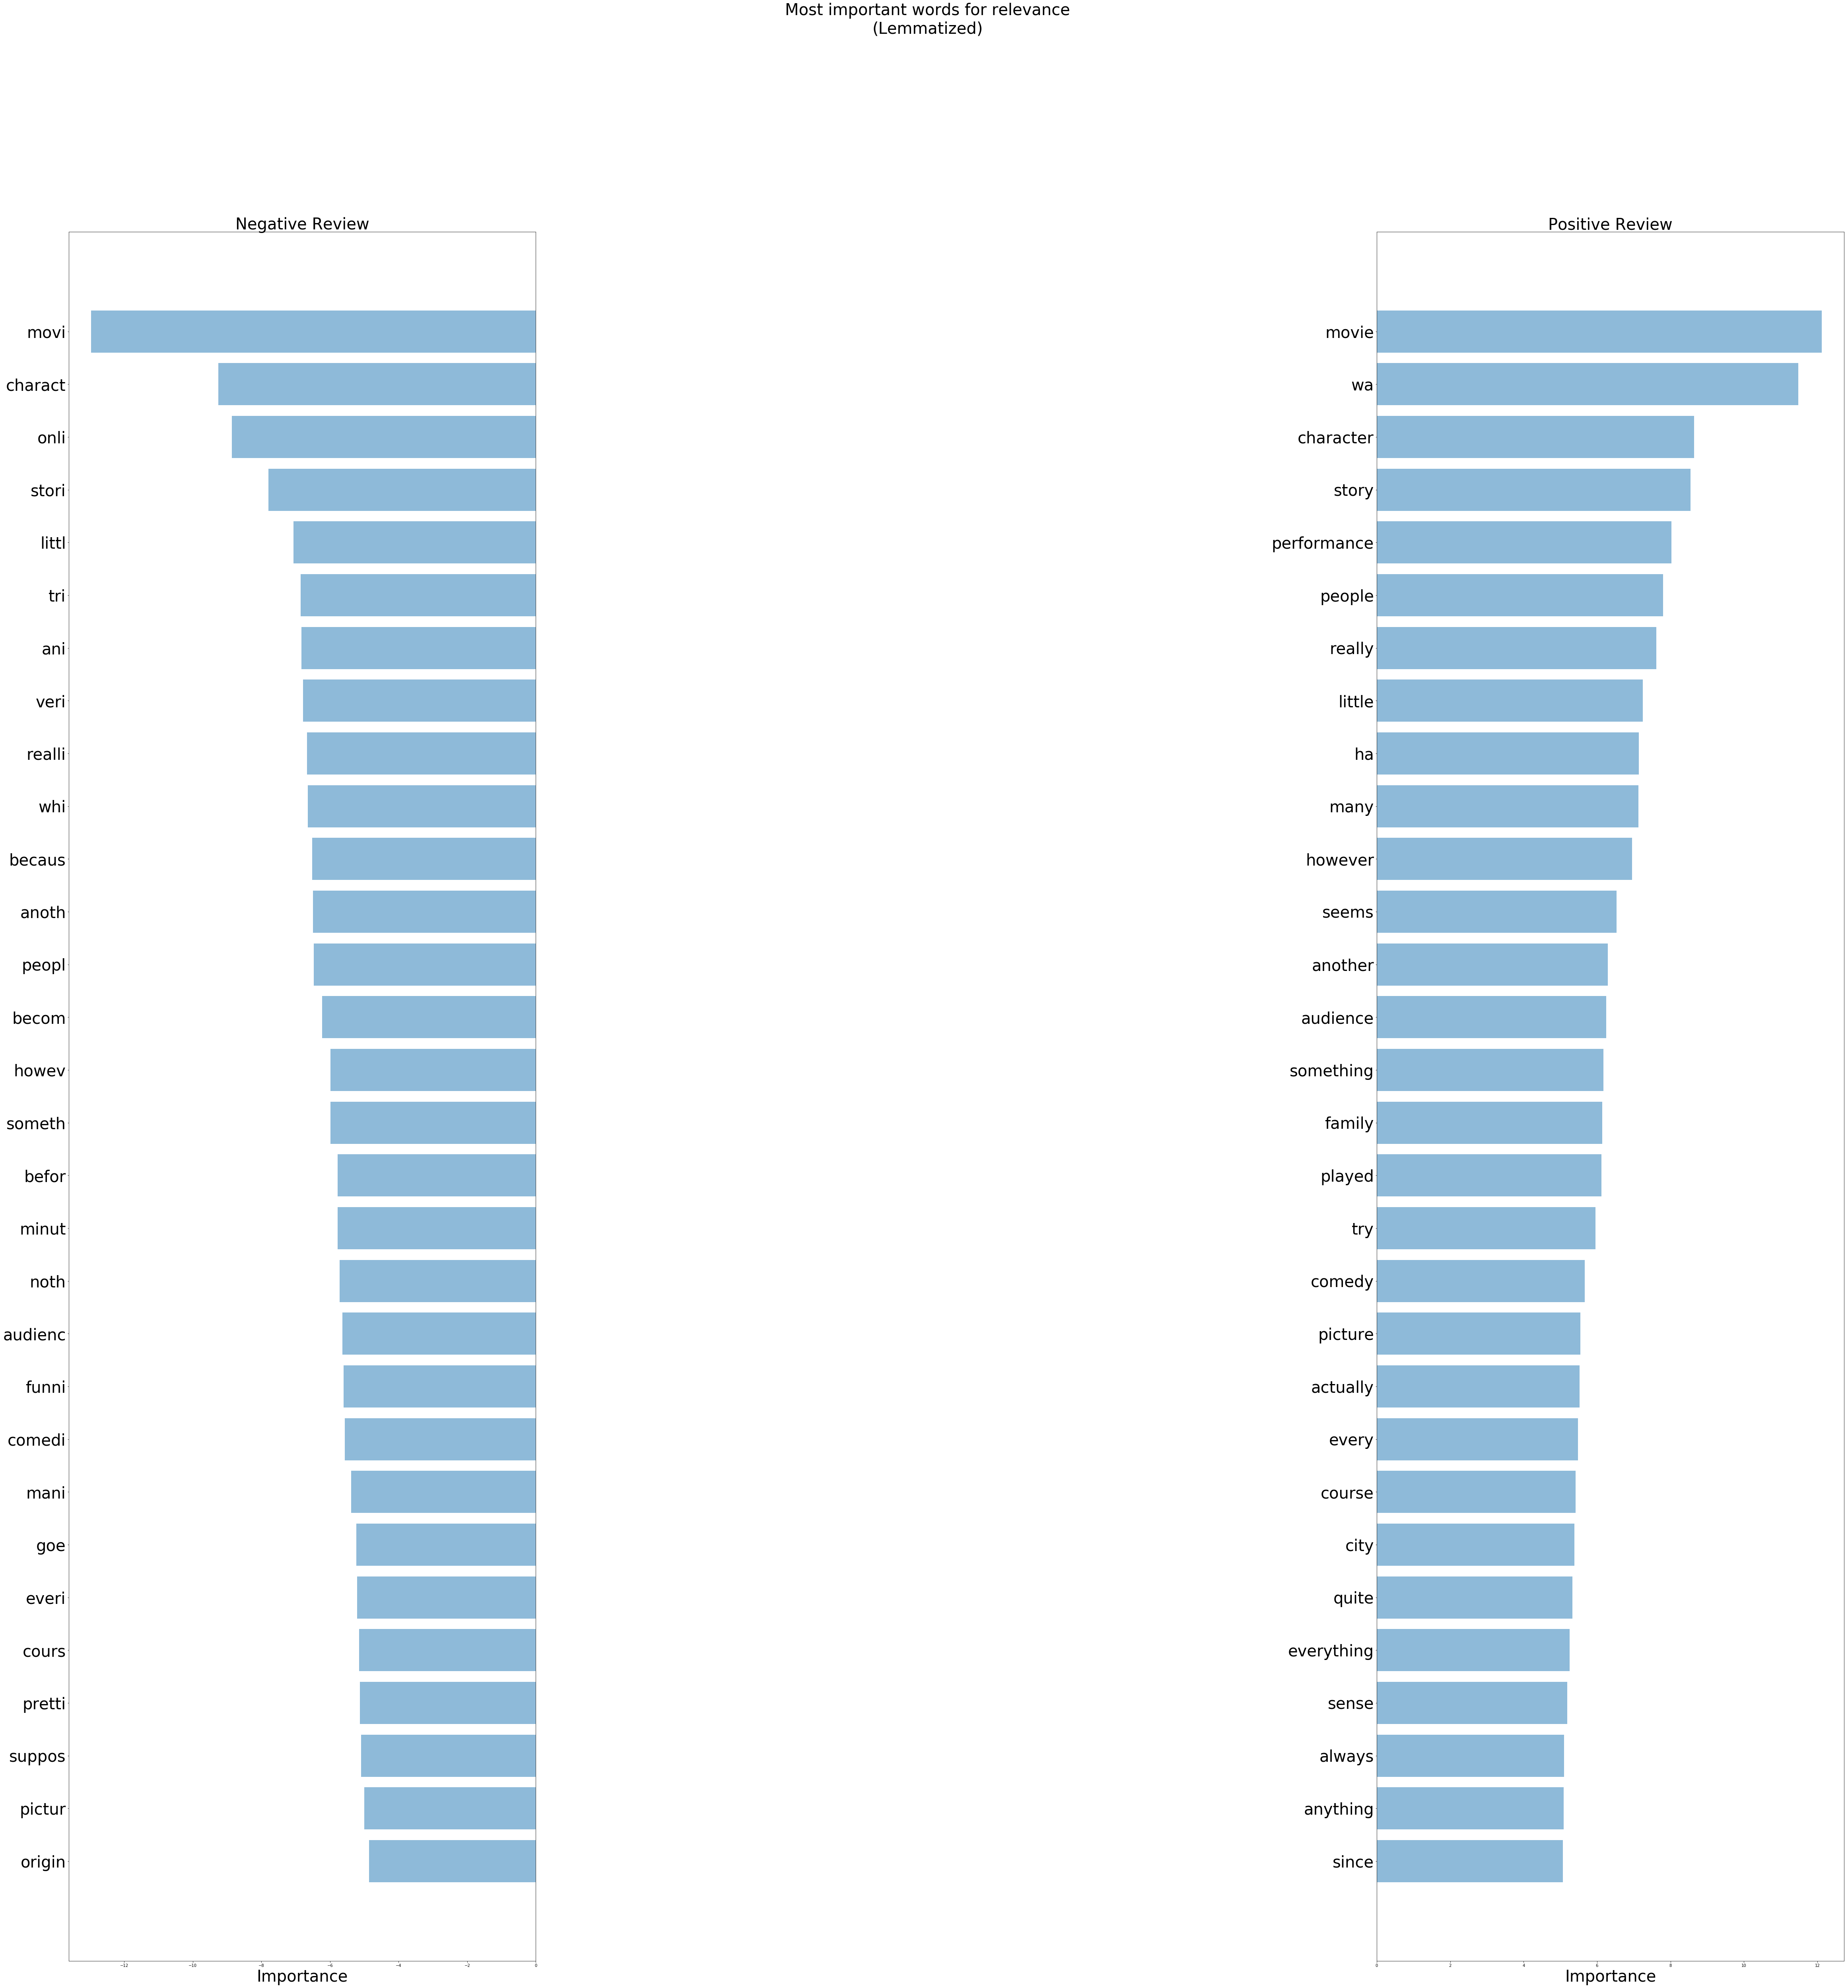

In [19]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(80, 80))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Review', fontsize=40)
    plt.yticks(y_pos, bottom_words, fontsize=40)
    plt.suptitle('Key words', fontsize=40)
    plt.xlabel('Importance', fontsize=40)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Review', fontsize=40)
    plt.yticks(y_pos, top_words, fontsize=40)
    plt.suptitle(name, fontsize=40)
    plt.xlabel('Importance', fontsize=40)
    
    plt.subplots_adjust(wspace=1.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance\n(Lemmatized)")

accuracy= 0.9275224215246637
             precision    recall  f1-score   support

          0       0.95      0.90      0.92      8778
          1       0.91      0.95      0.93      9062

avg / total       0.93      0.93      0.93     17840



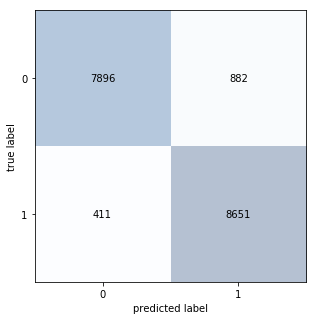

In [20]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
clf=MultinomialNB()
clf.fit(x_train,y_train)
pred= clf.predict(x_test)
from sklearn.metrics import classification_report , accuracy_score
print('accuracy=',accuracy_score(y_test,pred))
print(classification_report(y_test, pred))

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

accuracy= 0.9387892376681615
             precision    recall  f1-score   support

          0       0.89      0.99      0.94      8778
          1       0.99      0.88      0.94      9062

avg / total       0.94      0.94      0.94     17840



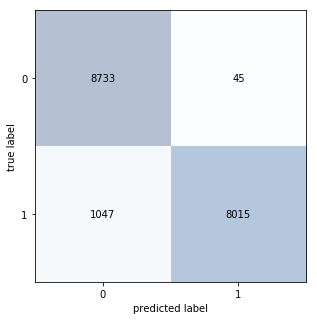

In [21]:
clf=BernoulliNB()
clf.fit(x_train,y_train)
pred= clf.predict(x_test)
from sklearn.metrics import classification_report , accuracy_score
print('accuracy=',accuracy_score(y_test,pred))
print(classification_report(y_test, pred))

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier()
clf.fit(x_train,y_train)
pred= clf.predict(x_test)
from sklearn.metrics import classification_report , accuracy_score
print('accuracy=',accuracy_score(y_test,pred))
print(classification_report(y_test, pred))

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()